# Dataset: Fake Amazon Reviews

The dataset for this model was found on OSF, an open source repository for research data. The link to the csv file used can be found [here](https://osf.io/tyue9/#!). 

There are only five attributes found within the dataset:
- Category of product the review is found in (Electronics, Home and Kitchen, etc)
- The rating left by the reviewer on a scale of 1-5
- The classification of the review being Bot-generated (CG) or human-generated (OR)
- The actual text of the review

More attributes will be added to aid the training of the model such as:

- word count
- sentiment
    - This might seem not completely necessary since the ratings should indicate the reviewers sentiment, however fake reviews can often have conflicting sentiment and rating which could aid the classification



# Business Case

As online shopping continues to become the predominant way people purchase products, the importance of transparency cannot be understated. A 2020 study found that approximately 42% of Amazon reviews were fake. Efforts are being made to reduce this number but inevitably many will slip through the cracks. Misleading reviews can harm not only the consumer, but the companies selling through online retail. A fake review may be considered when a customer is researching a product, which may lead them to be disappointed when the actual product is not of the quality they expected. Fake reviews can also hurt businesses if harmful reviews are made by competing companies. 


source: [business insider](https://www.businessinsider.com/guides/tech/amazon-fake-reviews)

# Using NLP to differentiate bot-generated reviews from human-generated reviews

## Import necessary libraries

In [1]:
import pandas as pd
import nltk
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nkirbabas\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Importing csv file with amazon reviews

In [2]:
#dataset contains about 40,000 reviews; 20,000 fake and 20,000 real
df = pd.read_csv('amazon_reviews.csv')

print(df.shape)
df.head()

(40432, 4)


,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [3]:
df.describe()

,rating
count,40432.000000
mean,4.256579
std,1.144354
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Not very useful information given most of the data is text based. Attributes will need to be added but first, the data will need cleaning to fix: casing, punctuation, stop word removal, and removal of low quality or duplicate data (if any)

## Data Cleaning

In [4]:
df.drop_duplicates(subset='text_', inplace=True)
df = df[df['text_'].notna()]
df.shape

(40412, 4)

Removed 20 records that were not useful which is a good start.

In [5]:
#Normalize text by making all words lowercase
df['text_'] = df['text_'].str.lower()

#removing all punctuation
df['text_'] = df['text_'].str.replace('[^\w\s]','')

In [6]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,love this well made sturdy and very comfortab...
1,Home_and_Kitchen_5,5,CG,love it a great upgrade from the original ive...
2,Home_and_Kitchen_5,5,CG,this pillow saved my back i love the look and ...
3,Home_and_Kitchen_5,1,CG,missing information on how to use it but it is...
4,Home_and_Kitchen_5,5,CG,very nice set good quality we have had the set...


More attributes can be added now that there is easy to work with text. First let's look at the amount of words in each review.

In [7]:
#loops over every review and counts the # of words using blank space as delimiter
df['totalwords'] = [len(x.split()) for x in df['text_'].tolist()]
df.describe()

,rating,totalwords
count,40412.000000,40412.000000
mean,4.256409,67.342027
std,1.144538,69.426342
min,1.000000,0.000000
25%,4.000000,21.000000
50%,5.000000,39.000000
75%,5.000000,85.000000
max,5.000000,373.000000


In [8]:
#adding sentiment analyzer and using compound score
df['sentiment'] = df['text_'].apply(
    lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])


In [9]:
df.head()

,category,rating,label,text_,totalwords,sentiment
0,Home_and_Kitchen_5,5,CG,love this well made sturdy and very comfortab...,12,0.9538
1,Home_and_Kitchen_5,5,CG,love it a great upgrade from the original ive...,16,0.8910
2,Home_and_Kitchen_5,5,CG,this pillow saved my back i love the look and ...,14,0.7906
3,Home_and_Kitchen_5,1,CG,missing information on how to use it but it is...,17,0.7227
4,Home_and_Kitchen_5,5,CG,very nice set good quality we have had the set...,18,0.7397


The nltk sentiment intensity analyzer uses the vader lexicon to create an overall score of how positive or negative the review is on a scale from -1 to 1. -1 being a review that is extremely negative, 0 being a completely neutral review, and 1 being extremely positive. As we can see from the code preview, review 3 has a review rating of 1 for the product, yet the sentiment seems to be overall very positive. This could be something indicative of a bot review; when a review rating and body have a disconnect. 

Now it's time to remove stop words so we can look at the distribution of words and eventually the tf-idf values of the dataset

In [10]:
#install the necessary libraries and words
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nkirbabas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nkirbabas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nkirbabas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now all the reviews have been separated into individual words. It's time to remove the stop words from the reviews

In [11]:
#removing stop words from tokenized reviews and then lemmatizing 

#initialize lemmatizer
lemmatizer = WordNetLemmatizer()

#creating function to remove stop words and then lemmatize
def clean_review(review):
    words = word_tokenize(review)
    no_stop_words = [w for w in words if not w in stop_words]
    lemmatized_review = [lemmatizer.lemmatize(word) for word in no_stop_words]
    return ' '.join(lemmatized_review)

In [12]:
df['processed_review'] = df['text_'].apply(clean_review)

In [14]:
print(df['text_'][1])
print(df['processed_review'][1])

love it a great upgrade from the original  ive had mine for a couple of years
love great upgrade original ive mine couple year


Looks like the reviews have been successfully trimmed of all stop words and lemmatized. Now we can finally use tf-idf

In [15]:
#instantiate the tfidf 
tfidf = TfidfVectorizer() 

#using the lemmatized and cleaned review for tfidf
X_tfidf = tfidf.fit_transform(df['processed_review'])

Now that we have the TF-IDF Vectorization done, we are going to bring together TF-IDF and sentiment to be the feature that is trained, using hstack. 

In [22]:
from scipy.sparse import hstack

#need to create variable to store sentiment and converting to float
X_sentiment = np.array(df['sentiment']).reshape(-1,1)

X = hstack((X_tfidf, X_sentiment))

## Creating Base Model

The base model used will be a logistic regression. This is because logistic regression are a simple yet reliable method for classification problems. 

In [39]:
#need to encode the labels CG and OR to 0 and 1 for later tests
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['label'])

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=7)
#import sklearn logisitic regression
from sklearn.linear_model import LogisticRegression   

#creating logistic regression model

#max iter had to be increased as it was causing issues
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [40]:
#lets try to test the data now that the model has been trained
y_pred = clf.predict(X_test)

Time to look at the models performance. We'll be looking at the accuracy, precision, Recall, and F1 Score

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy", accuracy_score(y_test,y_pred))
print("Precision", precision_score(y_test,y_pred))
print("Recall", recall_score(y_test,y_pred))
print("F1 Score", f1_score(y_test,y_pred))

Accuracy 0.8728194977112458
Precision 0.8589378852536748
Recall 0.8932445759368837
F1 Score 0.8757553782934494


C:\Users\nkirbabas\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

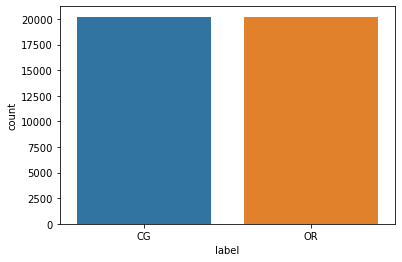

In [20]:
sns.countplot(df.label)

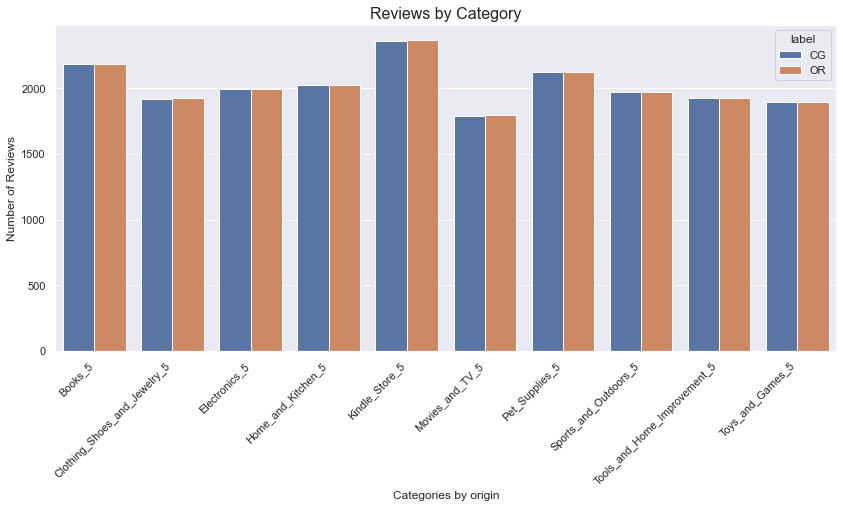

In [77]:
#creating separate df to look at the # of each category by who wrote it
reviews_per_category = df.groupby(['category',
                                   'label']).size().reset_index(name='count')
plt.figure(figsize=(14,6))
chart = sns.barplot(x = 'category', y = 'count', hue='label',
            data = reviews_per_category)
#add chart title
plt.title('Reviews by Category', fontsize=16)

#add axis titles
plt.xlabel('Categories by origin')
plt.ylabel('Number of Reviews')

#rotate x-axis labels
plt.xticks(rotation=45, ha='right');